In [1]:
import time
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

import os
import sys
sys.path.insert(0, os.path.dirname('../'))

from config import Config
from data_utils import video_to_frames
from data_utils import metadata_loader
from data_utils import dataset_builder

from models.C3D import C3D_model, Small_C3D, Bigger_C3D
import pickle

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix
CLASS_NAMES = os.listdir("/home/jupyter/video-based-human-activity-recognition/data/kth-actions/video")

def kth_confusion_matrix(model, dataset):
    onehot_targets = [sample[1].numpy() for sample in dataset]
    onehot_targets = np.concatenate(onehot_targets, axis=0)
    targets = np.argmax(onehot_targets, axis=1)

    onehot_preds = model.predict(dataset)
    preds = np.argmax(onehot_preds, axis=1)
    conf = confusion_matrix(targets, preds)
    
    fig = plt.figure()
    ax = plt.subplot()
    sns.heatmap(conf, annot=True, ax=ax, cmap=sns.cubehelix_palette(8), fmt='g',
        xticklabels=CLASS_NAMES,
        yticklabels=CLASS_NAMES)
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    #fig.savefig(path+"/confmax.pdf")
    plt.show()


# Load KTH  dataset

In [3]:
from data_utils.kth_dataset_builder import DatasetBuilder

# Setup builder
builder = DatasetBuilder(
    video_path='../data/kth-actions/video_trimmed',
    frame_path='../data/kth-actions/frame_trimmed',
    img_width=120, img_height=120, ms_per_frame=100,max_frames=25)

# Convert videos and generate metadata
#builder.convert_videos_to_frames()
metadata = builder.generate_metadata()

# Build datasets
train_dataset = builder.make_video_dataset(metadata=metadata['train'])
valid_dataset = builder.make_video_dataset(metadata=metadata['valid'])
test_datasest = builder.make_video_dataset(metadata=metadata['test'])

IMG_SIZE = 160 # All images will be resized to 160x160

def preproces(image, label):
    #image = (image/255)
    return image, label

train = train_dataset.map(preproces)
validation = valid_dataset.map(preproces)
test = test_datasest.map(preproces)


# Verify that the datasets work
for vid, label in train.batch(2).take(3):
    print(vid.shape, label.shape)

train

(2, 25, 120, 120, 1) (2, 6)
(2, 25, 120, 120, 1) (2, 6)
(2, 25, 120, 120, 1) (2, 6)


<MapDataset shapes: ((None, 120, 120, 1), (6,)), types: (tf.float32, tf.int32)>

#  Load a not that big version of c3d

In [10]:
input_shape = (25, 120, 120, 1)
model= Small_C3D(input_shape, 6)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
1 (Conv3D)                   (None, 25, 120, 120, 16)  448       
_________________________________________________________________
4 (Conv3D)                   (None, 25, 120, 120, 32)  13856     
_________________________________________________________________
5 (MaxPooling3D)             (None, 9, 40, 40, 32)     0         
_________________________________________________________________
7 (Conv3D)                   (None, 9, 40, 40, 64)     55360     
_________________________________________________________________
10 (Conv3D)                  (None, 9, 40, 40, 128)    221312    
_________________________________________________________________
11 (MaxPooling3D)            (None, 3, 14, 14, 128)    0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 3, 14, 14, 128)   

In [11]:
history = model.fit(train.shuffle(150).batch(15), validation_data=validation.batch(1), epochs=70)
model.compile(loss='hinge', optimizer=tf.keras.optimizers.RMSprop(momentum=0.001), metrics=['acc'])
# model.compile(loss='hinge', optimizer='adam', metrics=['acc'])
model.compile(loss='hinge', optimizer=tf.keras.optimizers.Adadelta(lr=0.1,rho=0.8), metrics=['acc'])
model.fit(train.shuffle(150).batch(15), validation_data=validation.batch(1), epochs=20)

Train for 112 steps, validate for 359 steps
Epoch 1/70
112/112 [==============================] - 107s 952ms/step - loss: 0.4977 - accuracy: 0.5093 - val_loss: 0.5313 - val_accuracy: 0.1950
Epoch 2/70
112/112 [==============================] - 96s 855ms/step - loss: 0.2817 - accuracy: 0.6740 - val_loss: 0.5444 - val_accuracy: 0.5348
Epoch 3/70
112/112 [==============================] - 106s 945ms/step - loss: 0.2362 - accuracy: 0.7427 - val_loss: 0.4223 - val_accuracy: 0.3955
Epoch 4/70
112/112 [==============================] - 96s 853ms/step - loss: 0.2067 - accuracy: 0.7982 - val_loss: 0.3276 - val_accuracy: 0.6685
Epoch 5/70
112/112 [==============================] - 97s 869ms/step - loss: 0.1879 - accuracy: 0.8137 - val_loss: 0.2431 - val_accuracy: 0.7632
Epoch 6/70
112/112 [==============================] - 106s 947ms/step - loss: 0.1696 - accuracy: 0.8573 - val_loss: 0.2010 - val_accuracy: 0.8440
Epoch 7/70
112/112 [==============================] - 106s 950ms/step - loss: 0.164

In [13]:
np.mean([model.evaluate(test_datasest.batch(1))[1] for _ in range(10)])

357/357 [==============================] - 15s 42ms/step - loss: 0.0939 - acc: 0.9132


0.91932774

In [14]:
np.mean([model.evaluate(validation.batch(1))[1] for _ in range(10)])

359/359 [==============================] - 15s 42ms/step - loss: 0.0911 - acc: 0.9164


0.92534816

['handclapping', 'handwaving', 'boxing', 'jogging', 'walking', 'running']

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:40: MatplotlibDeprecationWarning: Unrecognized location 'bottom left'. Falling back on 'best'; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center
This will raise an exception in 3.3.


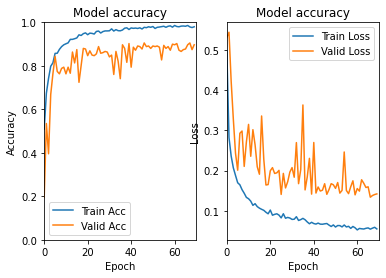

INFO:tensorflow:Assets written to: /home/jupyter/LOGS/trimmed_c3d_120_120_25frames_100ms/assets
Dumping the logs to  /home/jupyter/LOGS/trimmed_c3d_120_120_25frames_100ms/logs.pkl


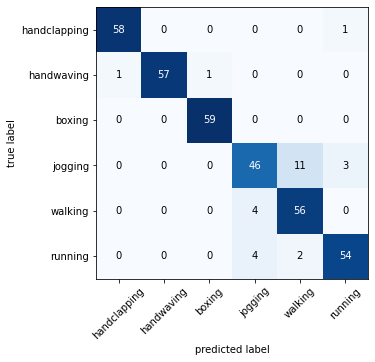

In [18]:
log(model, test, history, "trimmed_c3d_120_120_25frames_100ms")

In [16]:
import os
from sklearn.metrics import confusion_matrix
from mlxtend.plotting import plot_confusion_matrix

CLASS_NAMES = os.listdir("/home/jupyter/video-based-human-activity-recognition/data/kth-actions/video")

def log(model, test_ds, history_tuned, path):
# %% history storage
    history_tuned_saved = []
    history_tuned_saved.append(history_tuned)
    folder_path = "/home/jupyter/LOGS/"+path
    os.mkdir(folder_path)
    # %% PLOTTING
    def plot(history, y_pred, y_test):
        acc = []
        acc_val = []
        loss = []
        loss_val = []
        for i in range(len(history)):
            acc += history[i].history['accuracy']
            acc_val += history[i].history['val_accuracy']
            loss += history[i].history['loss']
            loss_val += history[i].history['val_loss']
        plt.subplot(1, 2, 1)
        plt.plot(acc, label="Train Acc")
        plt.plot(acc_val, label="Valid Acc")
        plt.xlabel("Epoch")
        plt.xlim(0, len(acc))
        plt.ylabel("Accuracy")
        plt.ylim(0, 1)
        plt.legend()
        plt.title("Model accuracy")

        plt.subplot(1, 2, 2)
        plt.plot(loss, label="Train Loss")
        plt.plot(loss_val, label="Valid Loss")
        plt.xlabel("Epoch")
        plt.xlim(0, len(acc))
        plt.ylabel("Loss")
        plt.legend(loc="bottom left")
        plt.title("Model accuracy")
        plt.savefig(folder_path+"/acc_loss", bbox_inches='tight')
        plt.show()
        cmat = confusion_matrix(y_test, y_pred)
        cmat_plot = plot_confusion_matrix(conf_mat=cmat, figsize=(5, 5),
                                          class_names=CLASS_NAMES)
        plt.savefig(folder_path+"/confusion_matrix", bbox_inches='tight')
        return [acc, acc_val, loss, loss_val]


    # %%
    y_test = [np.argmax(l.numpy()) for _, l in test_ds.batch(1)]
    y_pred_tuned = model.predict_classes(test_ds.batch(1),batch_size=None)


    # %%
    logs = plot(history_tuned_saved, y_pred_tuned, y_test)
    model.save(folder_path)
    # %%
    save_logs_to = folder_path+"/logs.pkl"
    if os.path.exists(save_logs_to):
        print("File already exits, please try another path or filename")

    else:
        print("Dumping the logs to ", save_logs_to)
        with open(save_logs_to, 'wb') as f:
            obj = {
                'acc': logs[0],
                'acc_val': logs[1],
                'loss': logs[2],
                'loss_val': logs[3],
                'y_test': y_test,
                'y_pred': y_pred_tuned}
            pickle.dump(obj, f)


In [113]:
pip install mlxtend

     |████████████████████████████████| 1.3 MB 14.9 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.
